El objetivo de este notebook es hacer una implementación rápida de un Decision Tree y ganar intuición sobre la forma de tomar las decisiones.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/repo_tesis/entorno_tesis_Molina"
!source bin/activate

Mounted at /content/drive
/content/drive/My Drive/repo_tesis/entorno_tesis_Molina


In [2]:
!pip install comet_ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.1/663.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.6/281.6 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.1/979.1 kB 22.1 MB/s eta 0:00:00
  Attempting uninstall: python-box
    Found existing installation: python-box 7.1.1
    Uninstalling python-box-7.1.1:
      Successfully uninstalled python-box-7.1.1


In [3]:
import numpy as np
import joblib
import sys
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from comet_ml import Experiment
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# Importar los datos
features = joblib.load("/content/drive/My Drive/repo_tesis/src/datos_definitivos/FEATURES_W200_I50.joblib")
label = joblib.load("/content/drive/My Drive/repo_tesis/src/datos_definitivos/label_W200_I50.joblib")

features_array = np.array(features)
label_array = np.array(label)

In [ ]:
# %cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest"

# folds_ind = joblib.load('folds_W200_I50_sujetoTest_' + str(2) + '.pkl')
# sujetos_array = joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(2) + '.pkl')

# print(folds_ind)
# print(sujetos_array)

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest
[array([ 5558,  5559,  5560, ..., 12118, 12119, 12120]), array([   0,    1,    2, ..., 5555, 5556, 5557]), array([12121, 12122, 12123, ..., 17671, 17672, 17673]), array([17674, 17675, 17676, ..., 24621, 24622, 24623]), array([24624, 24625, 24626, ..., 31115, 31116, 31117]), array([31118, 31119, 31120, ..., 37990, 37991, 37992]), array([37993, 37994, 37995, ..., 44782, 44783, 44784]), array([44785, 44786, 44787, ..., 51319, 51320, 51321]), array([51322, 51323, 51324, ..., 57842, 57843, 57844]), array([57845, 57846, 57847, ..., 64523, 64524, 64525])]
[1, 0, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest"

full_pipeline = Pipeline([
    # ('scaler', StandardScaler()),
    # ('pca', PCA(n_components=0.98)),
    ('et_classifier', ExtraTreesClassifier(random_state=42))
])


grilla_n_estimators = [5, 50, 75, 100, 500]

metricas_grilla = []
modelos_grilla = []

# busqueda de hiperparametros mediante validacion cruzada
for k in range(len(grilla_n_estimators)):
  metricas = []
  modelos = []
  for i in range(0, 10): # aca decido qué sujeto va para test
    # Importo particiones
    folds_ind = joblib.load('folds_W200_I50_sujetoTest_' + str(i+1) + '.pkl') # lista de listas. en cada elemento tengo la lista de indices de un fold
    sujetos_array = joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(i+1) + '.pkl')   # lista con todos los sujetos, donde el primero corresponde al de test

    # por el criterio elegido, se que el primer fold es para test, asi que lo saco
    fold_test = folds_ind[0]

    # ahora lo quito para no armar entrevero
    folds_ind = folds_ind[1:]
    sujetos_CV = sujetos_array[1:]   # me quedo solo con los sujetos que voy usar para hacer CV
    # voy a hacer cross validation a mano
    # defino los folds que tengo, voy a ir dejando en validacion de a 1
    num_folds = np.arange(0, 9)   # no importa que no coincida con el sujeto, es solo para recorrer cada fold, al final me puedo fijar a qué sujeto pertenecía

    precision_train = []
    accuracy_train = []
    recall_train = []
    precision_val = []
    accuracy_val = []
    recall_val = []
    guardar_modelos = []

    for ind_fold_val in num_folds:  # voy tomando los folds de validacion en orden segun folds_ind, es decir sujetos_array
      folds_ind_train = folds_ind.copy()
      folds_ind_train.pop(ind_fold_val)
      fold_ind_val = folds_ind[ind_fold_val]

      # concateno los arrays en uno solo
      folds_ind_train_array = np.concatenate(folds_ind_train)

      # aplanar el array resultante
      folds_ind_train_array = folds_ind_train_array.ravel()

      # concateno los arrays en uno solo
      fold_ind_val_array = np.array(fold_ind_val)

      # Defino X_train, y_train, X_val, y_val
      X_train = features_array[folds_ind_train_array, :]
      y_train = label_array[folds_ind_train_array, 1]

      X_val = features_array[fold_ind_val_array, :]
      y_val = label_array[fold_ind_val_array, 1]

      # ajusto el modelo con los datos de entrenamiento
      # modelo = DecisionTreeClassifier(max_depth=grilla_max_depth[k])
      # Configurar el parámetro en el clasificador dentro del pipeline
      full_pipeline.set_params(et_classifier__n_estimators=grilla_n_estimators[k])
      full_pipeline.fit(X_train, y_train)

      # calculo las predicciones sobre los datos de train y val
      y_pred_train = full_pipeline.predict(X_train)
      y_pred_val = full_pipeline.predict(X_val)

      # calculo metricas sobre conjunto de train y val
      precision_train.append(precision_score(y_train, y_pred_train, average='weighted'))
      precision_val.append(precision_score(y_val, y_pred_val, average='weighted'))
      accuracy_train.append(accuracy_score(y_train, y_pred_train))
      accuracy_val.append(accuracy_score(y_val, y_pred_val))
      recall_train.append(recall_score(y_train, y_pred_train, average='weighted'))
      recall_val.append(recall_score(y_val, y_pred_val, average='weighted'))
      guardar_modelos.append(full_pipeline)

        # Crear DataFrame
    data = {'Fold_val': sujetos_CV,
            'precision_train': precision_train,
            'precision_val': precision_val,
            'accuracy_train': accuracy_train,
            'accuracy_val': accuracy_val,
            'recall_train': recall_train,
            'recall_val': recall_val}

    df = pd.DataFrame(data)

    # para un valor del hiperparametro, guardo las metricas y modelos de los sujetos
    metricas.append(df)
    modelos.append(guardar_modelos)
  metricas_grilla.append(metricas)
  modelos_grilla.append(modelos)

joblib.dump(metricas_grilla, 'metricas_grilla_et_max_depth2.pkl')
joblib.dump(modelos_grilla, 'modelos_grilla_et_max_depth2.pkl')

'''
por cada sujeto que mando a test, tengo un dataFrame de metricas, donde cada fila corresponde a una iteracion de CV (usando un fold
de validacion distinto)
'''


/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest


In [ ]:
df.head(10)

,Fold_val,precision_train,precision_val,accuracy_train,accuracy_val,recall_train,recall_val
0,1,0.897404,0.257265,0.894552,0.253238,0.894552,0.253238
1,2,0.906530,0.246415,0.903492,0.248334,0.903492,0.248334
2,3,0.884359,0.294568,0.878600,0.286906,0.878600,0.286906
3,4,0.898499,0.282896,0.893681,0.281183,0.893681,0.281183
4,5,0.907484,0.156929,0.902137,0.158545,0.902137,0.158545
5,6,0.898558,0.200203,0.896044,0.205094,0.896044,0.205094
6,7,0.899809,0.240224,0.897580,0.231758,0.897580,0.231758
7,8,0.904470,0.240627,0.899590,0.240993,0.899590,0.240993
8,9,0.883015,0.183663,0.879588,0.180213,0.879588,0.180213


In [8]:
# Acceder a las metricas y modelos si los tengo guardados en un pkl
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/hello_world/resultados_preliminares"

# metricas_grilla = joblib.load("metricas_grilla_et_max_depth.pkl.pkl")
# modelos_grilla = joblib.load("modelos_grilla_et_max_depth.pkl.pkl")

metricas_grilla = joblib.load("HW_NP_ExtraTrees_sep_sub_CV_1test_metricas.pkl")
modelos_grilla = joblib.load("HW_NP_ExtraTrees_sep_sub_CV_1test.pkl")

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/hello_world/resultados_preliminares


In [9]:
print(modelos_grilla)

[[[Pipeline(steps=[('et_classifier',
                 ExtraTreesClassifier(max_depth=10, n_estimators=650,
                                      random_state=42))]), Pipeline(steps=[('et_classifier',
                 ExtraTreesClassifier(max_depth=10, n_estimators=650,
                                      random_state=42))]), Pipeline(steps=[('et_classifier',
                 ExtraTreesClassifier(max_depth=10, n_estimators=650,
                                      random_state=42))]), Pipeline(steps=[('et_classifier',
                 ExtraTreesClassifier(max_depth=10, n_estimators=650,
                                      random_state=42))]), Pipeline(steps=[('et_classifier',
                 ExtraTreesClassifier(max_depth=10, n_estimators=650,
                                      random_state=42))]), Pipeline(steps=[('et_classifier',
                 ExtraTreesClassifier(max_depth=10, n_estimators=650,
                                      random_state=42))]), Pipeline(steps=[('e

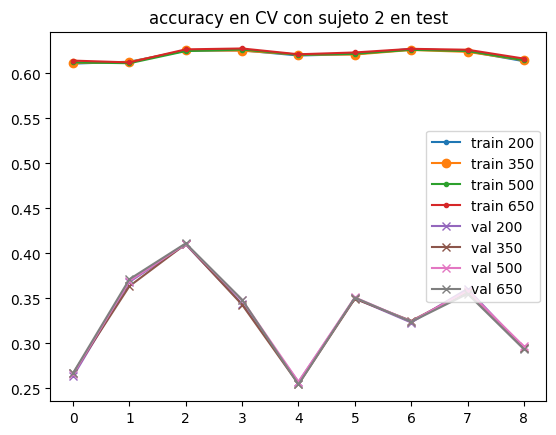

In [11]:
# el primer argumento controla la posicion de la grilla de hiperparametro
# el segundo controla el sujeto que miro
# metricas_grilla[3][0].accuracy_train # hiperparametro posicion 3, sujeto posicion 0 (sujeto 1)

i = 1   # elijo el sujeto que saco para test
# Voy a graficar accuracy para las diferentes metricas
plt.figure()
plt.title('accuracy en CV con sujeto ' + str(i+1) + ' en test')
plt.plot(metricas_grilla[0][i].accuracy_train, '.-')
plt.plot(metricas_grilla[1][i].accuracy_train, 'o-')
plt.plot(metricas_grilla[2][i].accuracy_train, '.-')
plt.plot(metricas_grilla[3][i].accuracy_train, '.-')

plt.plot(metricas_grilla[0][i].accuracy_val, 'x-')
plt.plot(metricas_grilla[1][i].accuracy_val, 'x-')
plt.plot(metricas_grilla[2][i].accuracy_val, 'x-')
plt.plot(metricas_grilla[3][i].accuracy_val, 'x-')
# plt.axis([0,8,0.99,1.01])

plt.legend(['train 200', 'train 350', 'train 500', 'train 650','val 200', 'val 350', 'val 500', 'val 650'])

# la mejor opcion parece max_depth=10

In [ ]:
# elijo el hiperparámetro óptimo en cada caso
params_opt = [200, 650, 350, 650, 650, 350, 650, 650, 350, 650]

In [ ]:
folds_ind = joblib.load('folds_W200_I50_sujetoTest_' + str(1) + '.pkl')
sujetos_array = joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(2) + '.pkl')

print(folds_ind)

[array([], dtype=int64), array([   0,    1,    2, ..., 5555, 5556, 5557]), array([ 5558,  5559,  5560, ..., 12118, 12119, 12120]), array([12121, 12122, 12123, ..., 17671, 17672, 17673]), array([17674, 17675, 17676, ..., 24621, 24622, 24623]), array([24624, 24625, 24626, ..., 31115, 31116, 31117]), array([31118, 31119, 31120, ..., 37990, 37991, 37992]), array([37993, 37994, 37995, ..., 44782, 44783, 44784]), array([44785, 44786, 44787, ..., 51319, 51320, 51321]), array([51322, 51323, 51324, ..., 57842, 57843, 57844])]


In [ ]:
grilla_n_estimators = [200, 350, 500, 650]
sujetos_array_lista = []
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest"
for i in range(0, 10): # aca decido qué sujeto va para test
  # Importo particiones
  sujetos_array_lista.append(joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(i+1) + '.pkl'))   # lista con todos los sujetos, donde el primero corresponde al de test

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest


In [ ]:
nombre = 'HW_NP_ExtraTrees_sep_sub_CV_1test'

joblib.dump(modelos_grilla, nombre + '.pkl')
joblib.dump(metricas_grilla, nombre + '_metricas.pkl')

API_KEY = 'ehXeElNypcj7Knar5zTmyjwSO'

exp = Experiment(api_key=API_KEY,
                project_name='tesis-experimentos', # Nombre del proyecto donde se registran los experimentos
                auto_param_logging=False)
exp.set_name(nombre) # Nombre de este experimento
exp.add_tags(['HelloWorld', 'ExtraTree', 'sep_sub', 'choose_test', 'gridSearch', 'CV']) # Tags

exp.log_parameter("particion_sujetos", sujetos_array_lista)   # Guarda el arreglo en el experimento
exp.log_parameter("param_grid", grilla_n_estimators)   # Guarda el arreglo en el experimento
exp.log_parameter("hiperparameter_name", 'n_estimators, max_depth=10')   # Guarda el arreglo en el experimento
exp.log_text("Se fija el sujeto de test, para cada una de las 10 CV (de cada valor del hiperparámetro). El primer sujeto del arreglo de sujetos es el de test (para cada uno de los 10 experimentos, está en orden).  Se hace una búsqueda del parámetro n_estimators. Se usa max_depth=10 y random_state=42.")   # Comentario del experimento
exp.log_model(name=nombre, file_or_folder=nombre + '.pkl')
exp.log_model(name=nombre + '_metricas', file_or_folder=nombre + '_metricas.pkl')

exp.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/manuelmolinach99/tesis-experimentos/f2cc899aea0342fbbfedbd1930c44d78

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : HW_NP_ExtraTrees_sep_sub_CV_1test
COMET INFO:     url                   : https://www.comet.com/manuelmolinach99/tesis-experimentos/f2cc899aea0342fbbfedbd1930c44d78
COMET INFO:   Others:
COMET INFO:     Name : HW_NP_ExtraTrees_sep_sub_CV_1te

# Entrenamiento y resultados en test

In [ ]:
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest"

full_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.98)),
    ('et_classifier', ExtraTreesClassifier(max_depth=10, random_state=42))
])

precision_train = []
accuracy_train = []
recall_train = []
precision_test = []
accuracy_test = []
recall_test = []
guardar_modelos = []
sujetos_test = []
for i in range(0, 10):
  folds_ind = joblib.load('folds_W200_I50_sujetoTest_' + str(i+1) + '.pkl') # lista de listas. en cada elemento tengo la lista de indices de un fold
  sujetos_array = joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(i+1) + '.pkl')   # lista con todos los sujetos, donde el primero corresponde al de test
  sujetos_test.append(sujetos_array[0])
  # por el criterio elegido, se que el primer fold es para test, asi que lo saco
  fold_test = folds_ind[0]

  # ahora lo quito para no armar entrevero
  folds_ind = folds_ind[1:]

  # concateno los arrays de train_ind en uno solo
  folds_ind_train_array = np.concatenate(folds_ind)
  # aplanar el array resultante
  folds_ind_train_array = folds_ind_train_array.ravel()

  # Defino X_train, y_train, X_val, y_val
  X_train = features_array[folds_ind_train_array, :]
  y_train = label_array[folds_ind_train_array, 1]

  X_test = features_array[fold_test, :]
  y_test = label_array[fold_test, 1]

  full_pipeline.set_params(et_classifier__n_estimators=params_opt[i])
  full_pipeline.fit(X_train, y_train)

  # calculo las predicciones sobre los datos de train y val
  y_pred_train = full_pipeline.predict(X_train)
  y_pred_test = full_pipeline.predict(X_test)

  # calculo metricas sobre conjunto de train y val
  precision_train.append(precision_score(y_train, y_pred_train, average='weighted'))
  precision_test.append(precision_score(y_test, y_pred_test, average='weighted'))
  accuracy_train.append(accuracy_score(y_train, y_pred_train))
  accuracy_test.append(accuracy_score(y_test, y_pred_test))
  recall_train.append(recall_score(y_train, y_pred_train, average='weighted'))
  recall_test.append(recall_score(y_test, y_pred_test, average='weighted'))
  guardar_modelos.append(full_pipeline)

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest


In [ ]:
joblib.dump(guardar_modelos, 'et_HW_scaled_pca_10_sep_sub_n_estimators_trainTest_modelos.pkl')

['et_HW_scaled_pca_10_sep_sub_n_estimators_trainTest_modelos.pkl']

In [ ]:
# Crear DataFrame
data = {'sujeto_test': sujetos_test,
        'precision_train': precision_train,
        'precision_test': precision_test,
        'accuracy_train': accuracy_train,
        'accuracy_test': accuracy_test,
        'recall_train': recall_train,
        'recall_test': recall_test}
data = pd.DataFrame(data)
joblib.dump(data, 'et_HW_scaled_pca_10_sep_sub_n_estimators_trainTest.pkl')

['et_HW_scaled_pca_10_sep_sub_n_estimators_trainTest.pkl']

In [ ]:
data.head(10)

,sujeto_test,precision_train,precision_test,accuracy_train,accuracy_test,recall_train,recall_test
0,0,0.669012,0.277510,0.596442,0.261065,0.596442,0.261065
1,1,0.682010,0.400287,0.606180,0.359744,0.606180,0.359744
2,2,0.668298,0.435040,0.597714,0.375653,0.597714,0.375653
3,3,0.686098,0.509111,0.607024,0.431655,0.607024,0.431655
4,4,0.684685,0.442043,0.610766,0.349861,0.610766,0.349861
5,5,0.677510,0.288379,0.606633,0.251200,0.606633,0.251200
6,6,0.682904,0.375367,0.605120,0.354535,0.605120,0.354535
7,7,0.684867,0.400671,0.613979,0.322166,0.613979,0.322166
8,8,0.682781,0.425888,0.611486,0.355818,0.611486,0.355818
9,9,0.685122,0.319873,0.604184,0.312378,0.604184,0.312378


In [ ]:
# Acceder a las metricas y modelos si los tengo guardados en un pkl
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/holaMundo/resultados_preliminares"

metricas_grilla = joblib.load("et_HW_NP_10_sep_sub_n_estimators_trainTest.pkl")
modelos_grilla = joblib.load("et_HW_NP_10_sep_sub_n_estimators_trainTest_modelos.pkl")

params_opt = [650, 650, 650, 650, 650, 650, 650, 650, 650, 650]
print(modelos_grilla)

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/holaMundo/resultados_preliminares
[Pipeline(steps=[('et_classifier',
                 ExtraTreesClassifier(max_depth=10, n_estimators=650,
                                      random_state=42))]), Pipeline(steps=[('et_classifier',
                 ExtraTreesClassifier(max_depth=10, n_estimators=650,
                                      random_state=42))]), Pipeline(steps=[('et_classifier',
                 ExtraTreesClassifier(max_depth=10, n_estimators=650,
                                      random_state=42))]), Pipeline(steps=[('et_classifier',
                 ExtraTreesClassifier(max_depth=10, n_estimators=650,
                                      random_state=42))]), Pipeline(steps=[('et_classifier',
                 ExtraTreesClassifier(max_depth=10, n_estimators=650,
                                      random_state=42))]), Pipeline(steps=[('et_classifier',
                 ExtraTreesClassifier(max_depth=10, n_es

In [ ]:
sujetos_array_lista = []
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest"
for i in range(0, 10): # aca decido qué sujeto va para test
  # Importo particiones
  sujetos_array_lista.append(joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(i+1) + '.pkl'))   # lista con todos los sujetos, donde el primero corresponde al de test

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest


In [ ]:
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/holaMundo/resultados_preliminares"

nombre = 'HW_NP_ExtraTrees_sep_sub_10exp_1test'

joblib.dump(modelos_grilla, nombre + '.pkl')
joblib.dump(metricas_grilla, nombre + '_metricas.pkl')

API_KEY = 'ehXeElNypcj7Knar5zTmyjwSO'

exp = Experiment(api_key=API_KEY,
                project_name='tesis-experimentos', # Nombre del proyecto donde se registran los experimentos
                auto_param_logging=False)
exp.set_name(nombre) # Nombre de este experimento
exp.add_tags(['HelloWorld', 'ExtraTrees', 'sep_sub', 'choose_test']) # Tags

exp.log_parameter("particion_sujetos", sujetos_array_lista)   # Guarda el arreglo en el experimento
exp.log_parameter("hiparams_usados", params_opt)   # Guarda el arreglo en el experimento
exp.log_parameter("hiperparameter_name", 'n_estimators, max_depth=10, random_state=42')   # Guarda el arreglo en el experimento
exp.log_text("Se guardan los modelos y metricas de 10 experimentos. En cada uno se usa la partición de particion_sujetos y el hiperparametro de hiparams_usados. Se usó max_depth=10 y random_state=42. Se fija el sujeto de test, siendo el primero del arreglo.")   # Comentario del experimento
exp.log_model(name=nombre, file_or_folder=nombre + '.pkl')
exp.log_model(name=nombre + '_metricas', file_or_folder=nombre + '_metricas.pkl')

exp.end()

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/holaMundo/resultados_preliminares


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/manuelmolinach99/tesis-experimentos/efc582d856684f3fa009ca22a6adbf29

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : HW_NP_ExtraTrees_sep_sub_10exp_1test
COMET INFO:     url                   : https://www.comet.com/manuelmolinach99/tesis-experimentos/efc582d856684f3fa009ca22a6adbf29
COMET INFO:   Others:
COMET INFO:     Name : HW_NP_ExtraTrees_sep_sub_10e